In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt


from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, make_scorer, f1_score, accuracy_score

In [2]:
with open('../data_for_classifier/AGdata031119.pkl','rb') as f:
    AG_geneIDs, AGdata_outcome, AGdata_clean,X, y, X_train, X_test, y_train, y_test,AG_geneIDs_test, AG_geneIDs_train = pickle.load(f)


In [3]:
AGdata_clean.drop(['CWSI', 'DSI', 'NTR', 'PSI', 'RSI'], axis=1, inplace=True)


X = StandardScaler().fit_transform(AGdata_clean)

y = AGdata_outcome
X_test = X[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP'),:]
X_train = X[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP') ,:]

y_test = y[(AG_geneIDs.Experiment=="T4_PEN")  | 
           (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP') ]
y_train = y[(AG_geneIDs.Experiment!="T4_PEN") & 
            (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP')]

AG_geneIDs_test = AG_geneIDs.loc[(AG_geneIDs.Experiment=="T4_PEN")  | 
                                 (AG_geneIDs.Experiment=="T4_CIP") | (AG_geneIDs.Experiment=='19F_CIP'),:]
AG_geneIDs_train = AG_geneIDs.loc[(AG_geneIDs.Experiment!="T4_PEN") & 
                                  (AG_geneIDs.Experiment!="T4_CIP") & (AG_geneIDs.Experiment!='19F_CIP'),:]

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype bool, uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [4]:
kappa_scorer = make_scorer(cohen_kappa_score)

def fit_model(myclf, traindata, testdata, trainoutcome, testoutcome):
    myclf.fit(traindata, trainoutcome)
    print("Best Model:")
    print(myclf.best_estimator_)
    
    y_pred_train = myclf.best_estimator_.predict(traindata)
    y_pred_test = myclf.best_estimator_.predict(testdata)
    
    y_predprob_train = myclf.best_estimator_.predict_proba(traindata)[:, 1]
    y_predprob_test = myclf.best_estimator_.predict_proba(testdata)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(trainoutcome, y_predprob_train)
    fpr_test, tpr_test, _ = roc_curve(testoutcome, y_predprob_test)
    
    acc_train = accuracy_score(trainoutcome, y_pred_train)
    acc_test = accuracy_score(testoutcome, y_pred_test)
    kap_train = cohen_kappa_score(trainoutcome, y_pred_train)
    kap_test = cohen_kappa_score(testoutcome, y_pred_test)
    
    cm_train = confusion_matrix(trainoutcome, y_pred_train)
    cm_test = confusion_matrix(testoutcome, y_pred_test)
    print("Training set confusion matrix:")
    print(cm_train)
    print("Test set confusion matrix:")
    print(cm_test)
    
    x = pd.DataFrame({'Train_Accuracy': [acc_train],
        'Test_Accuracy': [acc_test],
        'Train_Kappa': [kap_train],
        'Test_Kappa': [kap_test]})
    print(x)
    train_outcome_df = pd.DataFrame({'Outcome': trainoutcome,
                                    'Predicted': y_pred_train})
    test_outcome_df = pd.DataFrame({'Outcome': testoutcome,
                                   'Predicted': y_pred_test})
    
    
    # plot ROC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    
    return(myclf, x, train_outcome_df, test_outcome_df)

Best Model:
DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Training set confusion matrix:
[[20175   317]
 [    0    53]]
Test set confusion matrix:
[[5575  145]
 [  14    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0         0.98457        0.97228     0.247194    0.019607


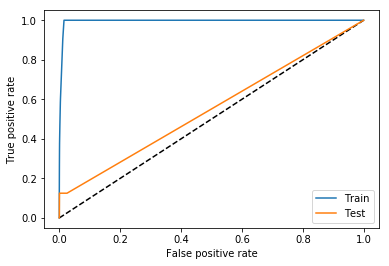

In [5]:
min_samples_split_DT = [3,4,5,6,7,8,9]
min_samples_leaf_DT = [3,4,5,6,7,8,9]
max_depth_DT = [3,4,5,6,7,8,9,10]
max_features_DT = ['sqrt', 'log2', None, 1, 2, 3, 4, 5]

parameters_DT = {#'max_features':max_features_DT,
                'min_samples_split': min_samples_split_DT,
                 'max_depth': max_depth_DT,
                'min_samples_leaf': min_samples_leaf_DT
                }

DT_model = DecisionTreeClassifier(random_state=0, splitter='best', criterion='gini', class_weight='balanced')
DT_clf = GridSearchCV(DT_model, parameters_DT, cv=5, scoring=kappa_scorer)
DT_clf, DT_performance, DT_train, DT_test = fit_model(DT_clf, X_train, X_test, y_train, y_test)
DT_train = pd.concat([DT_train, AG_geneIDs_train], axis=1)
DT_test = pd.concat([DT_test, AG_geneIDs_test], axis=1)

DT_train.to_csv('../predictors/dropoutMOA/DT_train.csv')
DT_test.to_csv('../predictors/dropoutMOA/DT_test.csv')

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

Best Model:
LogisticRegression(C=13.89495494373136, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)
Training set confusion matrix:
[[16235  4257]
 [    8    45]]
Test set confusion matrix:
[[4699 1021]
 [   6   10]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.792407       0.820955     0.015649    0.013684


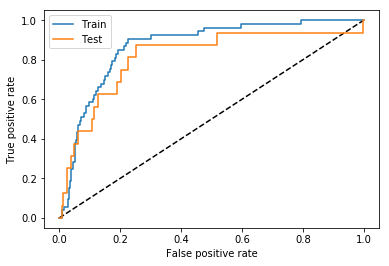

In [6]:
penalty_list_LR = ['l1','l2']
regularization_list_LR = [i for i in np.logspace(-4,2,15)]
parameters_LR = {'penalty':penalty_list_LR,
                'C': regularization_list_LR}

LR_model = LogisticRegression(class_weight = 'balanced')
LR_clf = GridSearchCV(LR_model, parameters_LR, cv=5, scoring=kappa_scorer)

LR_clf, LR_performance, LR_train, LR_test = fit_model(LR_clf, X_train, X_test, y_train, y_test)

LR_train = pd.concat([LR_train, AG_geneIDs_train], axis=1)
LR_test = pd.concat([LR_test, AG_geneIDs_test], axis=1)

LR_train.to_csv('../predictors/dropoutMOA/LR_train.csv')
LR_test.to_csv('../predictors/dropoutMOA/LR_test.csv')

Best Model:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='distance')
Training set confusion matrix:
[[20492     0]
 [    0    53]]
Test set confusion matrix:
[[5710   10]
 [  14    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.995816          1.0    0.140803


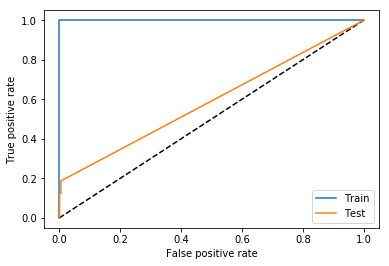

In [7]:
nneighbors_KNN = [i+2 for i in range(10)]
weights_list_KNN = ['uniform', 'distance']
parameters_KNN = {'n_neighbors':nneighbors_KNN,
                'weights': weights_list_KNN}
KNN_model = KNeighborsClassifier()
KNN_clf = GridSearchCV(KNN_model, parameters_KNN, cv=5, scoring=kappa_scorer)
KNN_clf, KNN_performance, KNN_train, KNN_test = fit_model(KNN_clf, X_train, X_test, y_train, y_test)

KNN_train = pd.concat([KNN_train, AG_geneIDs_train], axis=1)
KNN_test = pd.concat([KNN_test, AG_geneIDs_test], axis=1)

KNN_train.to_csv('../predictors/dropoutMOA/KNN_train.csv')
KNN_test.to_csv('../predictors/dropoutMOA/KNN_test.csv')

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
D:\defne\Apps\Anaconda\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The 

Best Model:
SVC(C=0.1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Training set confusion matrix:
[[18959  1533]
 [    1    52]]
Test set confusion matrix:
[[5268  452]
 [   6   10]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.925335       0.920153     0.058793    0.036647


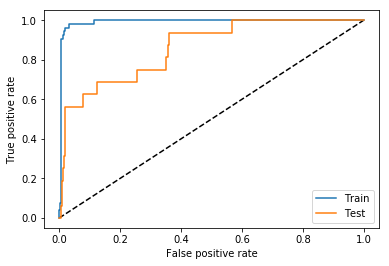

In [8]:
shrinking_list_SVM = [True, False]
regularization_list_SVM = [i for i in np.logspace(-4,-1,15)]
parameters_SVM = {'shrinking':shrinking_list_SVM,
                'C': regularization_list_SVM}

SVM_model = svm.SVC(class_weight='balanced', probability=True)
SVM_clf = GridSearchCV(SVM_model, parameters_SVM, cv=5, scoring=kappa_scorer)
SVM_clf, SVM_performance, SVM_train, SVM_test = fit_model(SVM_clf, X_train, X_test, y_train, y_test)

SVM_train = pd.concat([SVM_train, AG_geneIDs_train], axis=1)
SVM_test = pd.concat([SVM_test, AG_geneIDs_test], axis=1)

SVM_train.to_csv('../predictors/dropoutMOA/SVM_train.csv')
SVM_test.to_csv('../predictors/dropoutMOA/SVM_test.csv')

Best Model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Training set confusion matrix:
[[20492     0]
 [    0    53]]
Test set confusion matrix:
[[5717    3]
 [  16    0]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.996688          1.0   -0.000882


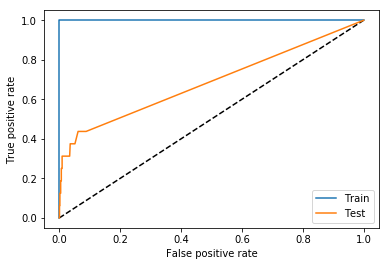

In [9]:
n_estimators_RF = [50, 100, 250, 500, 1000]
max_features_RF = [ None]
parameters_RF = {'n_estimators': n_estimators_RF,
                'max_features': max_features_RF}

RF_model = RandomForestClassifier(max_depth=None,
                                  min_samples_split=2, random_state=0)
RF_clf = GridSearchCV(RF_model, parameters_RF, cv=5, scoring=kappa_scorer)
RF_clf, RF_performance, RF_train, RF_test = fit_model(RF_clf, X_train, X_test, y_train, y_test)

RF_train = pd.concat([RF_train, AG_geneIDs_train], axis=1)
RF_test = pd.concat([RF_test, AG_geneIDs_test], axis=1)

RF_train.to_csv('../predictors/dropoutMOA/RF_train.csv')
RF_test.to_csv('../predictors/dropoutMOA/RF_test.csv')

Best Model:
MLPClassifier(activation='relu', alpha=1e-06, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Training set confusion matrix:
[[20490     2]
 [    5    48]]
Test set confusion matrix:
[[5702   18]
 [  15    1]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.999659       0.994247     0.931868    0.054279


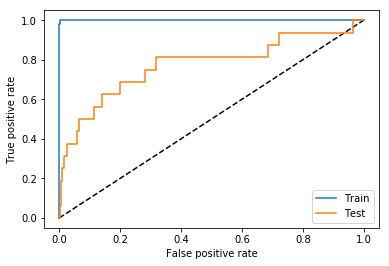

In [10]:
alpha_MLP = [i for i in 10.0 ** -np.arange(1,7)]
hidden_layer_sizes_MLP = [(10,10), (20,20), (40,40), 
                     (10,20),(10,40),(20,10), (40,10)]
parameters_MLP = {'alpha': alpha_MLP,
                 'hidden_layer_sizes': hidden_layer_sizes_MLP}

MLP_model = MLPClassifier(solver='lbfgs', 
                    random_state=1)
MLP_clf = GridSearchCV(MLP_model, parameters_MLP, cv=5, scoring=kappa_scorer)
MLP_clf, MLP_performance, MLP_train, MLP_test = fit_model(MLP_clf, X_train, X_test, y_train, y_test)

MLP_train = pd.concat([MLP_train, AG_geneIDs_train], axis=1)
MLP_test = pd.concat([MLP_test, AG_geneIDs_test], axis=1)

MLP_train.to_csv('../predictors/dropoutMOA/MLP_train.csv')
MLP_test.to_csv('../predictors/dropoutMOA/MLP_test.csv')

In [11]:
with open('../predictors/dropoutMOA/noMOA_RIFtrain.pkl','wb') as f:
    pickle.dump([DT_clf, LR_clf, SVM_clf, KNN_clf, RF_clf, MLP_clf], f)

In [12]:
allclf_train = AG_geneIDs_train
allclf_train['DT'] = DT_clf.best_estimator_.predict(X_train)
allclf_train['KNN'] = KNN_clf.best_estimator_.predict(X_train)
allclf_train['SVC'] = SVM_clf.best_estimator_.predict(X_train)
allclf_train['LR'] = LR_clf.best_estimator_.predict(X_train)
allclf_train['RF'] = RF_clf.best_estimator_.predict(X_train)
allclf_train['MLP'] = MLP_clf.best_estimator_.predict(X_train)

allclf_train['consensus_proba'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].mean(axis=1)

allclf_test = AG_geneIDs_test
allclf_test['DT'] = DT_clf.best_estimator_.predict(X_test)
allclf_test['KNN'] = KNN_clf.best_estimator_.predict(X_test)
allclf_test['SVC'] = SVM_clf.best_estimator_.predict(X_test)
allclf_test['LR'] = LR_clf.best_estimator_.predict(X_test)
allclf_test['RF'] = RF_clf.best_estimator_.predict(X_test)
allclf_test['MLP'] = MLP_clf.best_estimator_.predict(X_test)

X_consensus_train = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]
X_consensus_test = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']]

allclf_train['MajVoteProb'] = allclf_train[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6
allclf_test['MajVoteProb'] = allclf_test[['DT', 'KNN', 'SVC', 'LR', 'RF', 'MLP']].sum(axis=1)/6

DT_kappa = cohen_kappa_score(allclf_train.DT, y_train)
KNN_kappa = cohen_kappa_score(allclf_train.KNN, y_train)
SVC_kappa = cohen_kappa_score(allclf_train.SVC, y_train)
LR_kappa = cohen_kappa_score(allclf_train.LR, y_train)
RF_kappa = cohen_kappa_score(allclf_train.RF, y_train)
MLP_kappa = cohen_kappa_score(allclf_train.MLP, y_train)

allclf_train['WtdMajVoteProb'] = (allclf_train.DT * DT_kappa + allclf_train.KNN * KNN_kappa +
                                 allclf_train.SVC*SVC_kappa + allclf_train.LR*LR_kappa +
                                 allclf_train.RF*RF_kappa + allclf_train.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)

allclf_test['WtdMajVoteProb'] = (allclf_test.DT * DT_kappa + allclf_test.KNN * KNN_kappa +
                                 allclf_test.SVC*SVC_kappa + allclf_test.LR*LR_kappa +
                                 allclf_test.RF*RF_kappa + allclf_test.MLP*MLP_kappa)/(DT_kappa+KNN_kappa+SVC_kappa+LR_kappa+RF_kappa+MLP_kappa)

allclf_train.to_csv('../predictors/dropoutMOA/Consensus_vote_train.csv')
allclf_test.to_csv('../predictors/dropoutMOA/Consensus_vote_test.csv')

D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\defne\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [13]:
def eval_model(y_predprob_train, y_predprob_test, trainoutcome, testoutcome):
    
    y_pred_train = y_predprob_train>0.5
    y_pred_test = y_predprob_test>0.5
    
    fpr_train, tpr_train, _ = roc_curve(trainoutcome, y_predprob_train)
    fpr_test, tpr_test, _ = roc_curve(testoutcome, y_predprob_test)
    
    acc_train = accuracy_score(trainoutcome, y_pred_train)
    acc_test = accuracy_score(testoutcome, y_pred_test)
    kap_train = cohen_kappa_score(trainoutcome, y_pred_train)
    kap_test = cohen_kappa_score(testoutcome, y_pred_test)
    
    cm_train = confusion_matrix(trainoutcome, y_pred_train)
    cm_test = confusion_matrix(testoutcome, y_pred_test)
    print("Training set confusion matrix:")
    print(cm_train)
    print("Test set confusion matrix:")
    print(cm_test)
    
    x = pd.DataFrame({'Train_Accuracy': [acc_train],
        'Test_Accuracy': [acc_test],
        'Train_Kappa': [kap_train],
        'Test_Kappa': [kap_test]})
    print(x)
    train_outcome_df = pd.DataFrame({'Outcome': trainoutcome,
                                    'Predicted': y_pred_train})
    test_outcome_df = pd.DataFrame({'Outcome': testoutcome,
                                   'Predicted': y_pred_test})
    
    
    # plot ROC
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_train, tpr_train, label='Train')
    plt.plot(fpr_test, tpr_test, label='Test')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    

Training set confusion matrix:
[[20491     1]
 [    0    53]]
Test set confusion matrix:
[[5709   11]
 [  14    2]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0        0.999951       0.995642      0.99063     0.13577


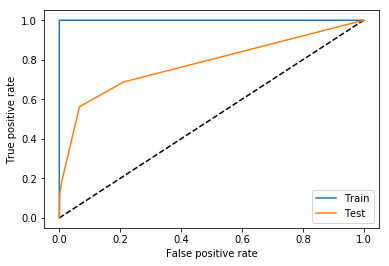

In [14]:
eval_model(allclf_train['MajVoteProb'], allclf_test['MajVoteProb'], y_train, y_test)

Training set confusion matrix:
[[20492     0]
 [    0    53]]
Test set confusion matrix:
[[5713    7]
 [  15    1]]
   Train_Accuracy  Test_Accuracy  Train_Kappa  Test_Kappa
0             1.0       0.996165          1.0    0.081626


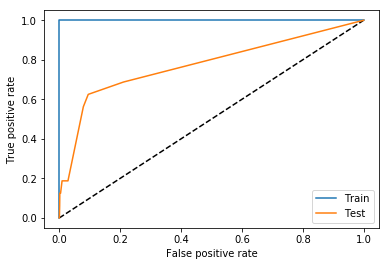

In [15]:
eval_model(allclf_train['WtdMajVoteProb'], allclf_test['WtdMajVoteProb'], y_train, y_test)